## Plot individual sample with Integrated Jsc

Short circuit current density for KG2_refcell_jsc_plot.png is 20.5688 mA/cm^2


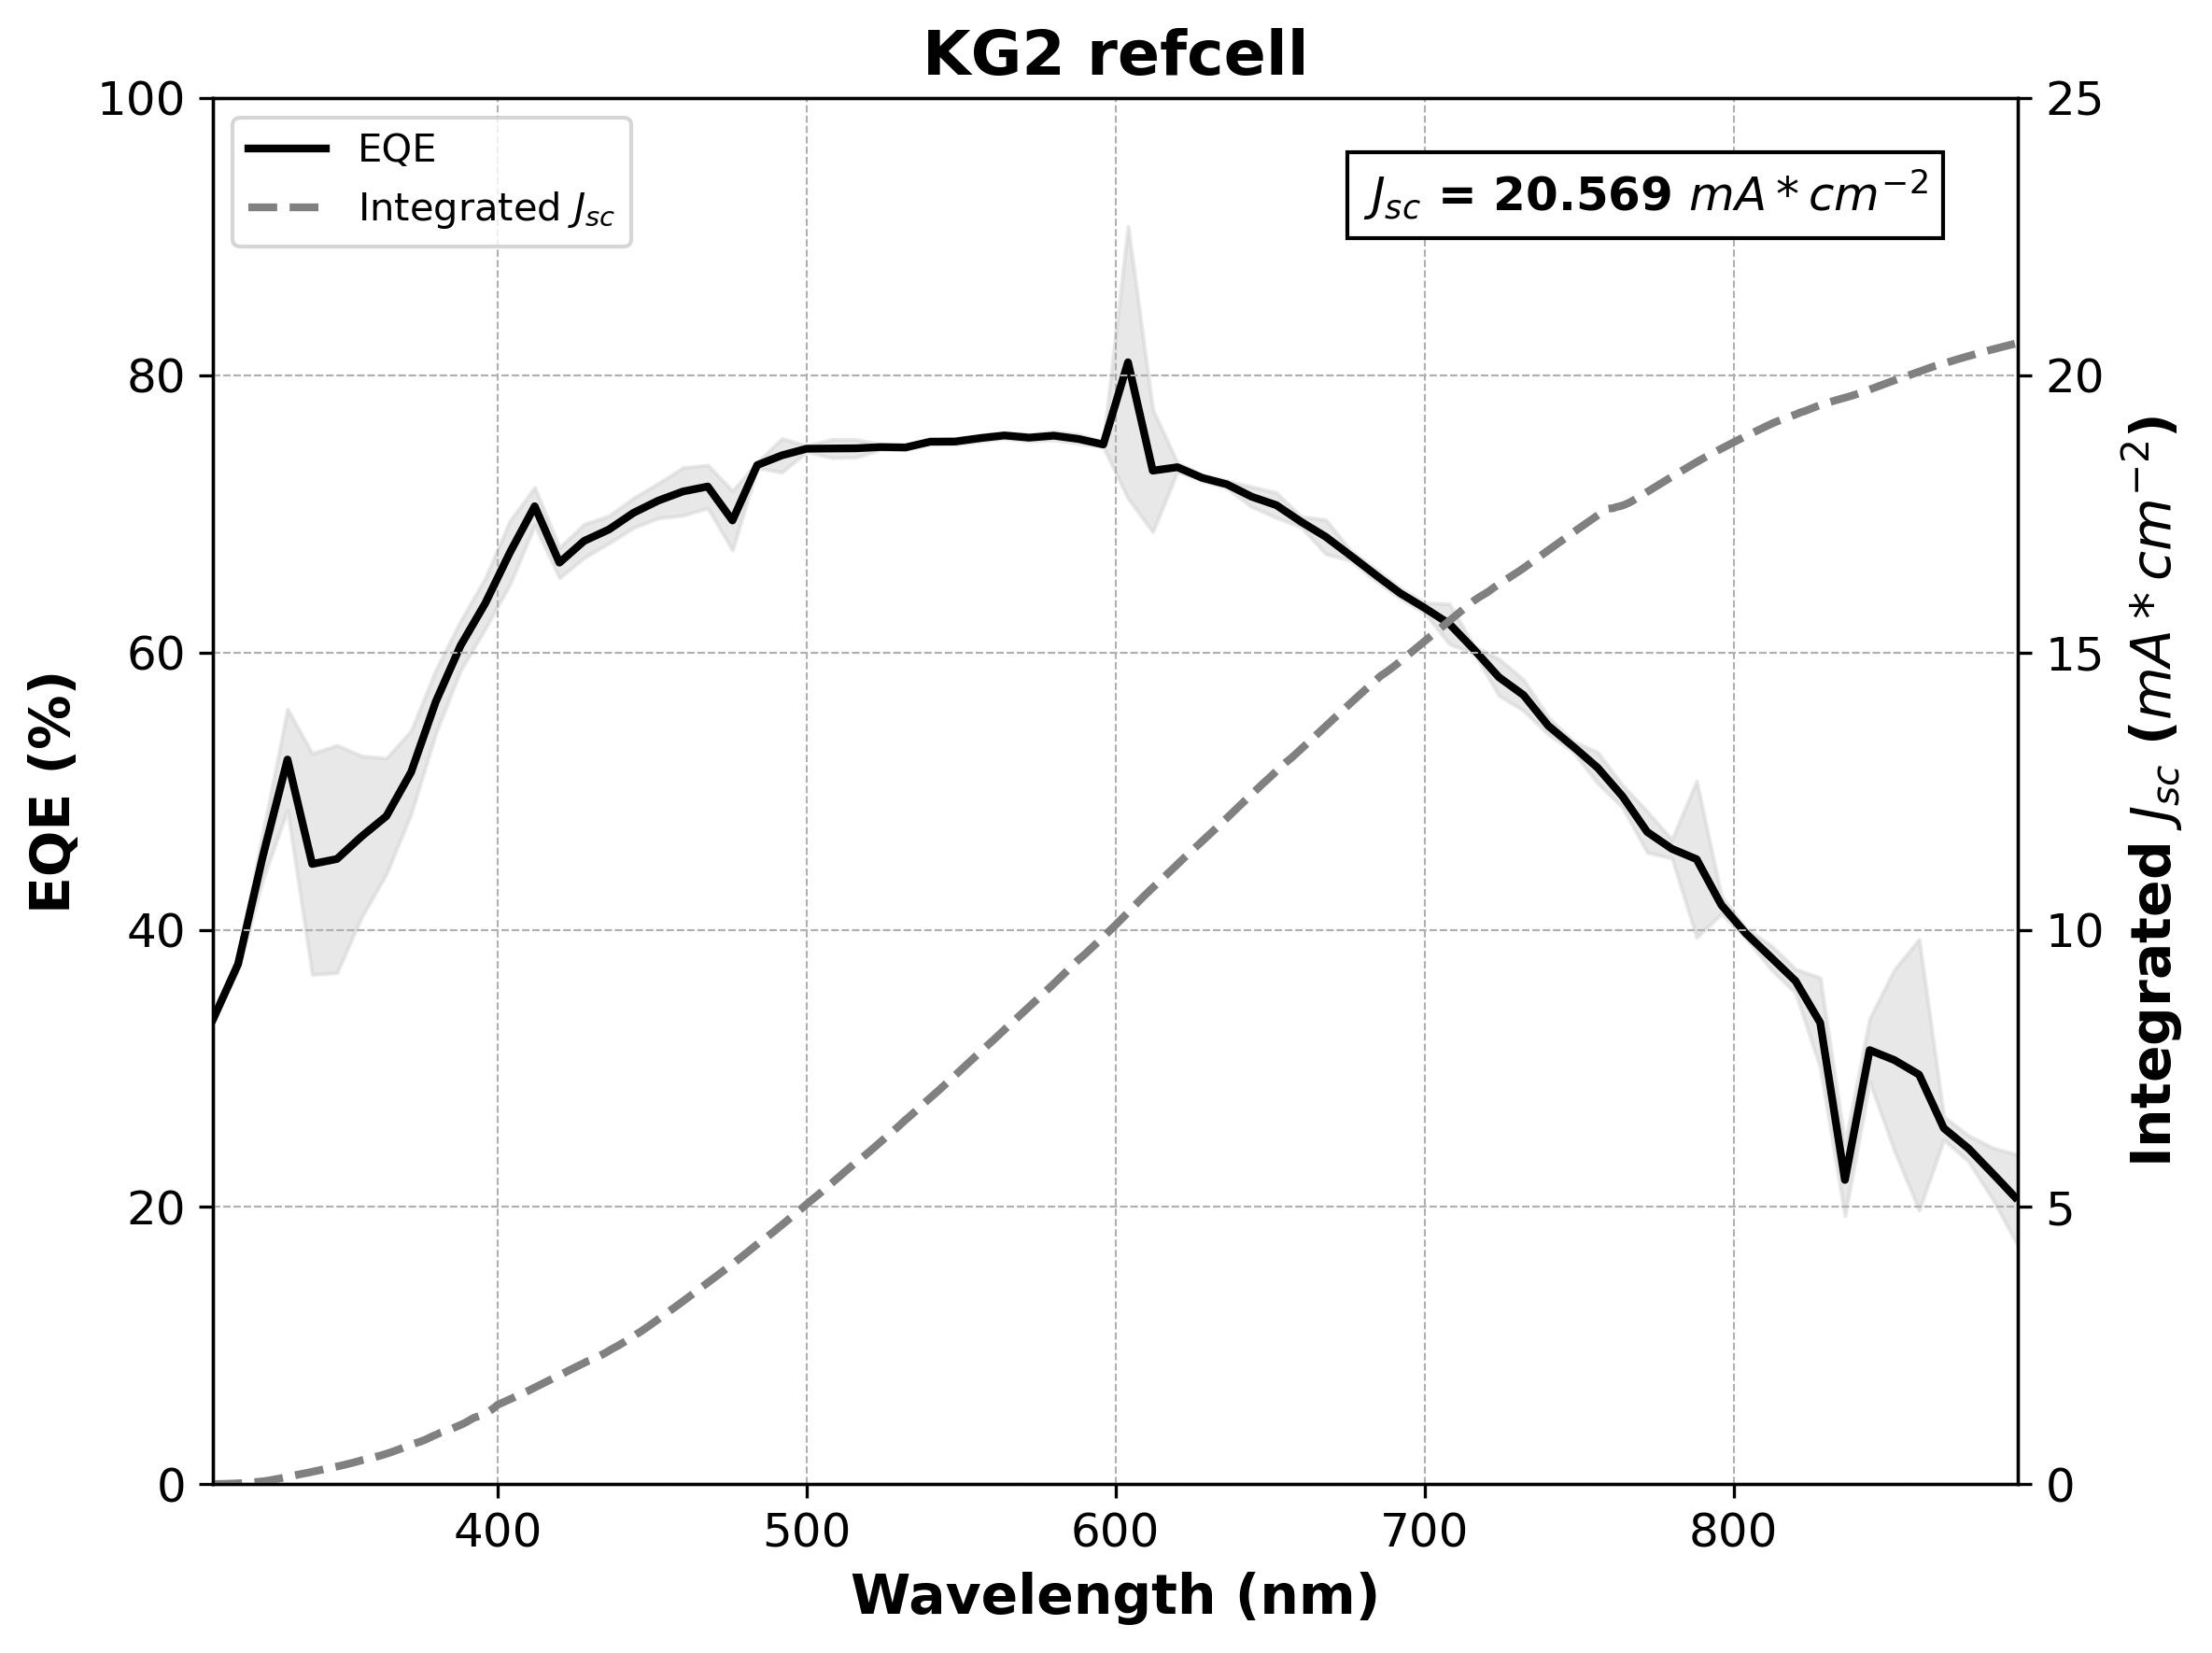

Short circuit current density for quartz_refcell_jsc_plot.png is 25.4852 mA/cm^2


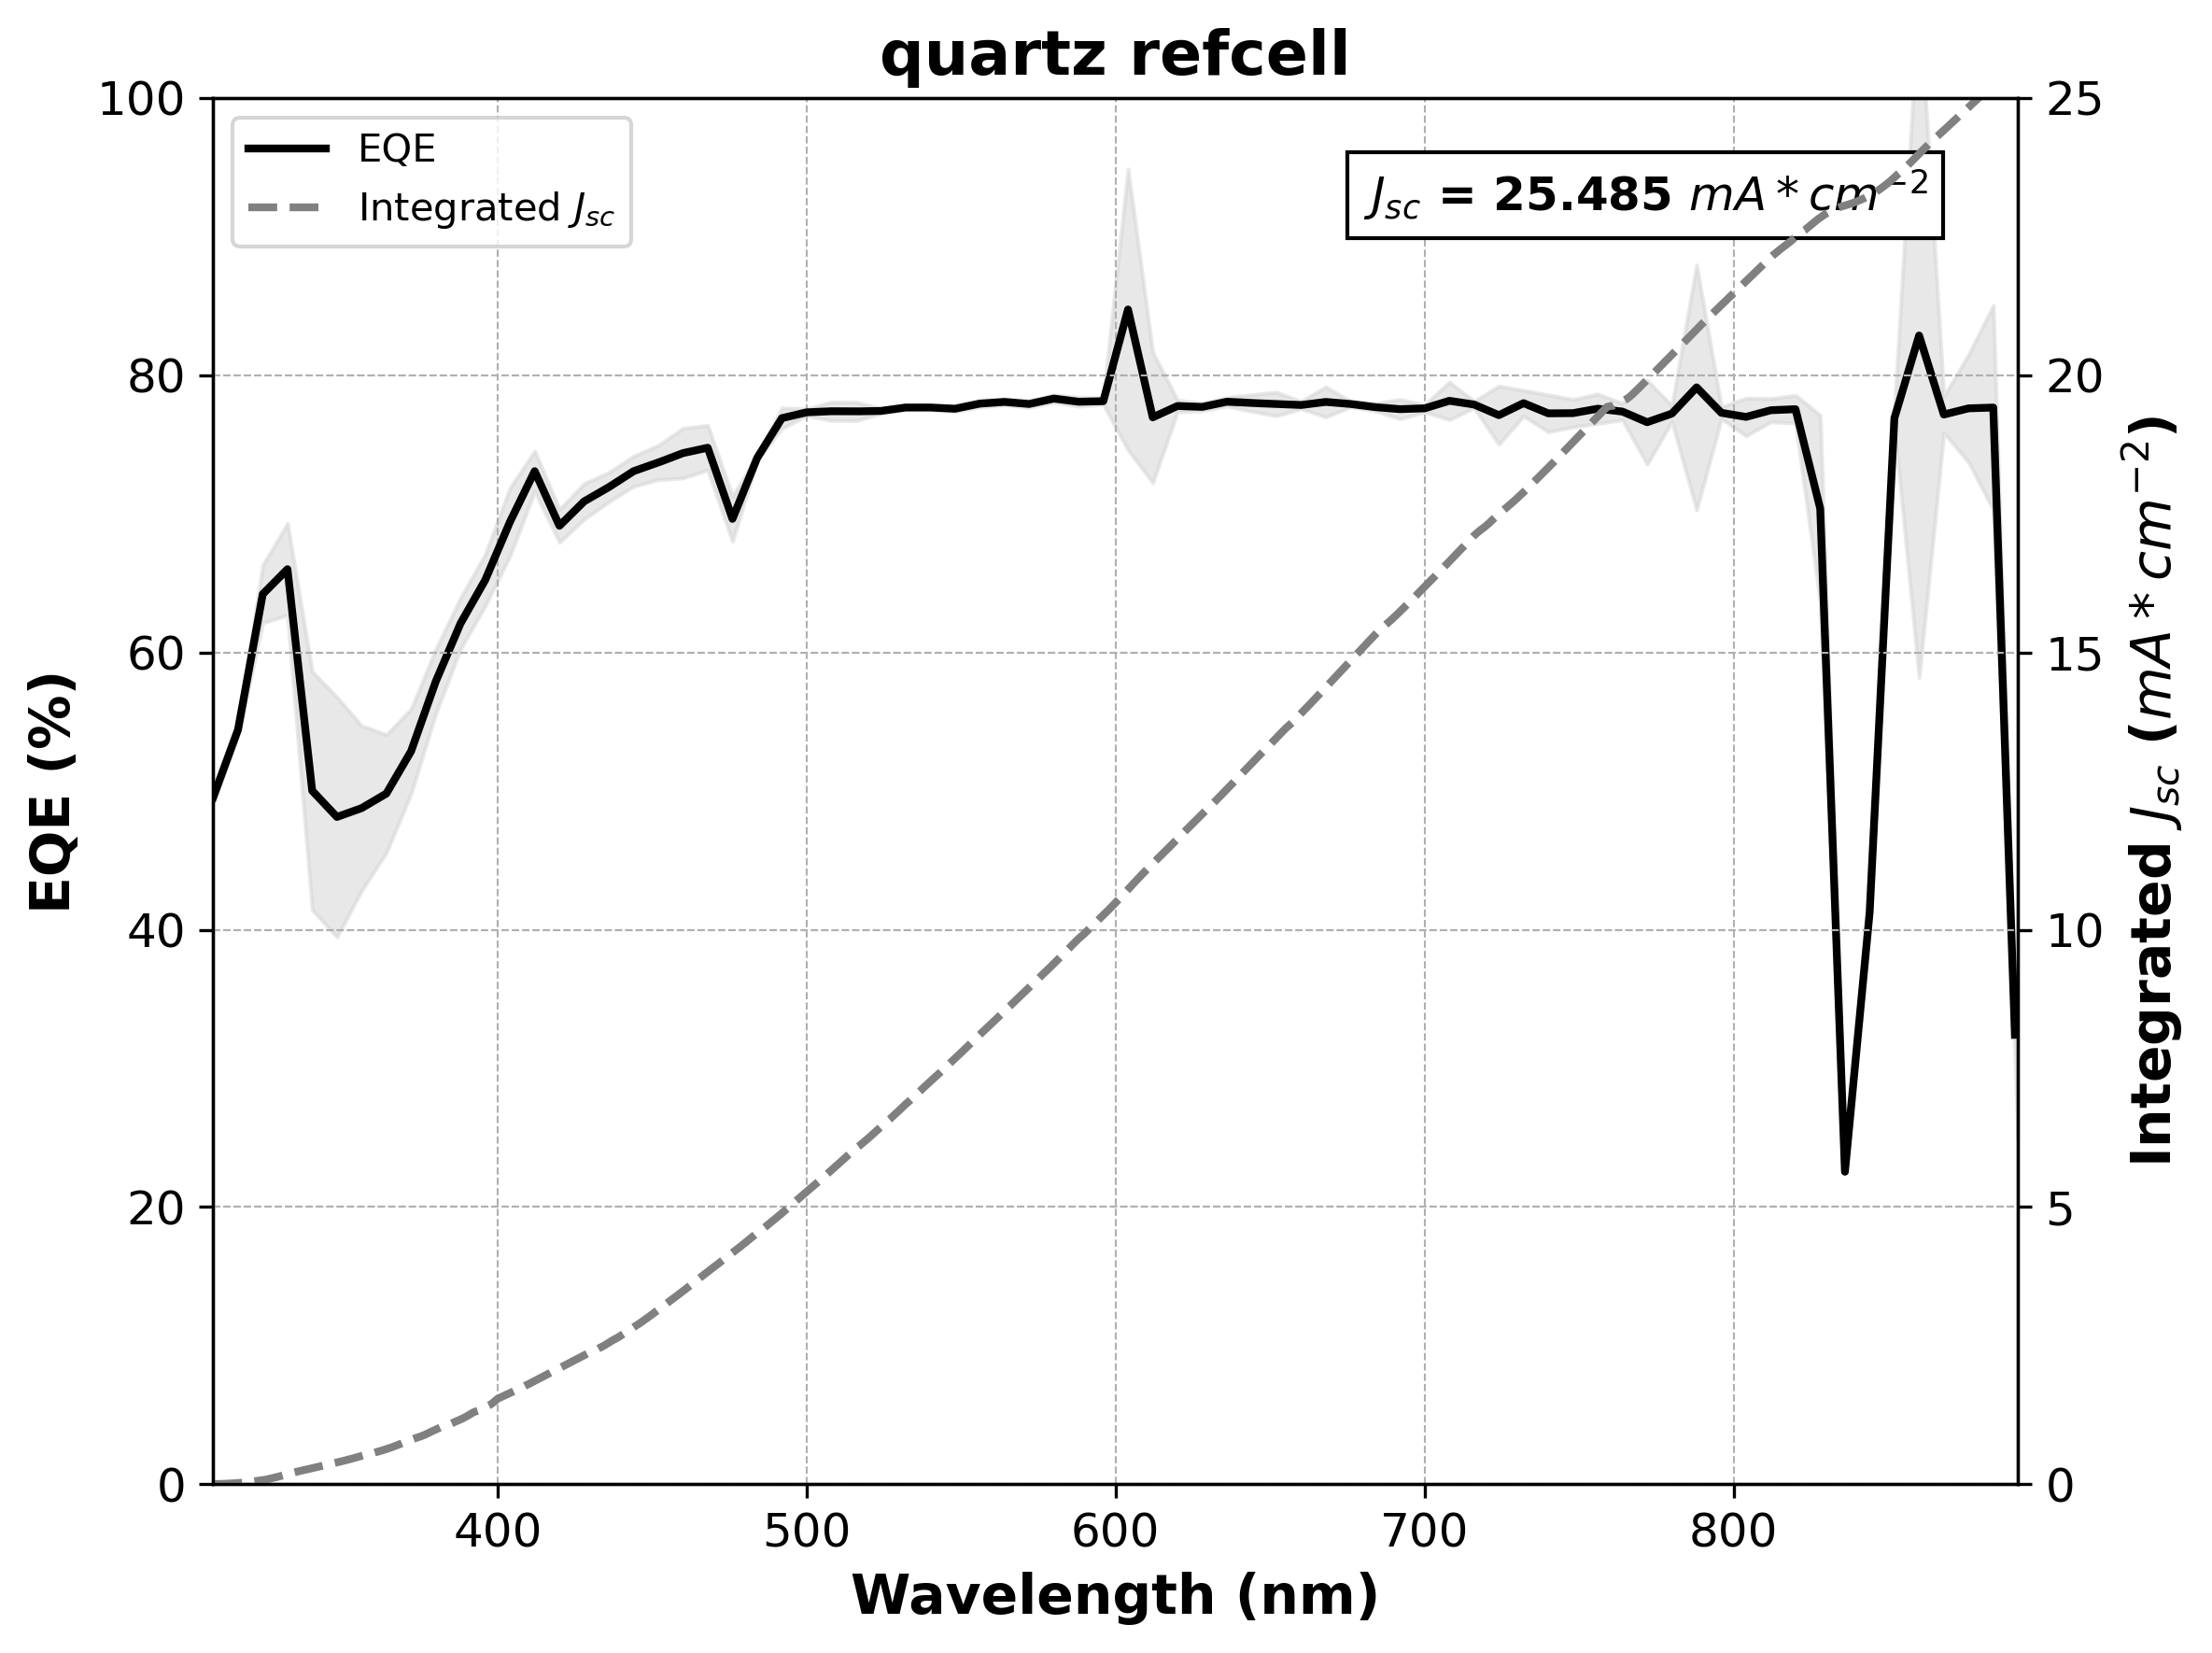

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Define helper function to find the nearest value in an array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# calc_jsc function
def calc_jsc(eqe_wls, eqe, eqe_error, spectrum_data, save_name=None):
    eqe_wls = np.asarray(eqe_wls)
    
    # Adjust to only use the relevant AM1.5 spectrum data within the EQE data wavelength range
    min_wavelength = min(eqe_wls)
    max_wavelength = max(eqe_wls)
    AM1p5 = spectrum_data[(spectrum_data['Wvlgth nm'] >= min_wavelength) & (spectrum_data['Wvlgth nm'] <= max_wavelength)]
    
    AM1p5_wls = AM1p5['Wvlgth nm']
    AM1p5_irr = AM1p5['Global tilt  W*m-2*nm-1']

    eqe_interp = interp1d(eqe_wls, eqe, kind='linear')

    max_ind = find_nearest(AM1p5_wls, eqe_wls[-1])
    min_ind = find_nearest(AM1p5_wls, eqe_wls[0])

    wls = AM1p5_wls[min_ind:max_ind]
    irr = AM1p5_irr[min_ind:max_ind]

    irr_photons = (wls * irr * 1e-9) / (1.988e-25)
    irr_photocurrent_density = (irr_photons / 1e4) * 1.602176634e-19 * 1000

    eqe_matched = eqe_interp(wls)
    jsc = sum(eqe_matched * irr_photocurrent_density)

    df = pd.DataFrame({
        'wls': wls,
        'eqe_matched': eqe_matched,
        'irr_photocurrent_density': irr_photocurrent_density,
    })
    df['cumsum'] = np.cumsum(df['eqe_matched'] * df['irr_photocurrent_density'])

    print(f'Short circuit current density for {save_name if save_name else "sample"} is {jsc:0.4f} mA/cm^2')

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax1 = ax.twinx()
    
    ax.plot(df['wls'], df['eqe_matched'] * 100, color='black', linewidth=2, label='EQE')
    ax.fill_between(eqe_wls, (eqe - eqe_error) * 100, (eqe + eqe_error) * 100, color='lightgrey', alpha=0.5)
    ax1.plot(df['wls'], df['cumsum'], color='grey', linewidth=2, linestyle='dashed', label=r'Integrated $J_{sc}$')

    ax.set_xlabel('Wavelength (nm)', fontsize=14, fontweight='bold')
    ax.set_ylabel('EQE (%)', fontsize=14, fontweight='bold')
    ax1.set_ylabel(r'Integrated $J_{sc}$ ($mA*cm^{-2}$)', fontsize=14, fontweight='bold')
    
    # Adjust the x-axis limits based on the EQE data
    ax.set_xlim(min_wavelength, max_wavelength)
    ax.set_ylim(0, 100)
    ax1.set_ylim(0, 25)

    sample_name = file.split('.')[0].replace('_', ' ').replace('jsc_plot', '') if save_name else "Sample"

    plt.title(sample_name, fontsize=16, fontweight='bold')

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize=10)
    # Display Jsc in the upper right-hand corner, 5% from the top and 5% from the right
    x_pos = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])
    y_pos = ax.get_ylim()[1] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.text(x_pos, y_pos, r'$J_{sc}$' + f' = {jsc:0.3f} ' + r'$mA*cm^{-2}$', fontsize=12, fontweight='bold', ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black'))

    if save_name:
        plt.tight_layout()
        plt.savefig(save_name, bbox_inches="tight")

    plt.show()
    return df

# Load the AM1.5 solar spectrum data from an Excel file
spectrum_data = pd.read_excel('AM1p5G.xls')

# List all CSV files in the directory
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

# Process each CSV file
for file in csv_files:
    eqe_data = pd.read_csv(file)
    
    # Check the first 3 EQE values and drop if they are greater than 1
    for wl in eqe_data['wls'].iloc[:3]:
        eqe_data = eqe_data.drop(eqe_data[(eqe_data['wls'] == wl) & (eqe_data['eqe'] > 1)].index)
    
    wavelengths = eqe_data['wls']
    eqe_values = eqe_data['eqe']
    eqe_errors = eqe_data['eqe_error']

    df = calc_jsc(wavelengths, eqe_values, eqe_errors, spectrum_data, save_name=file.split('.')[0] + '_jsc_plot.png')

plt.show()


## Plot all samples together

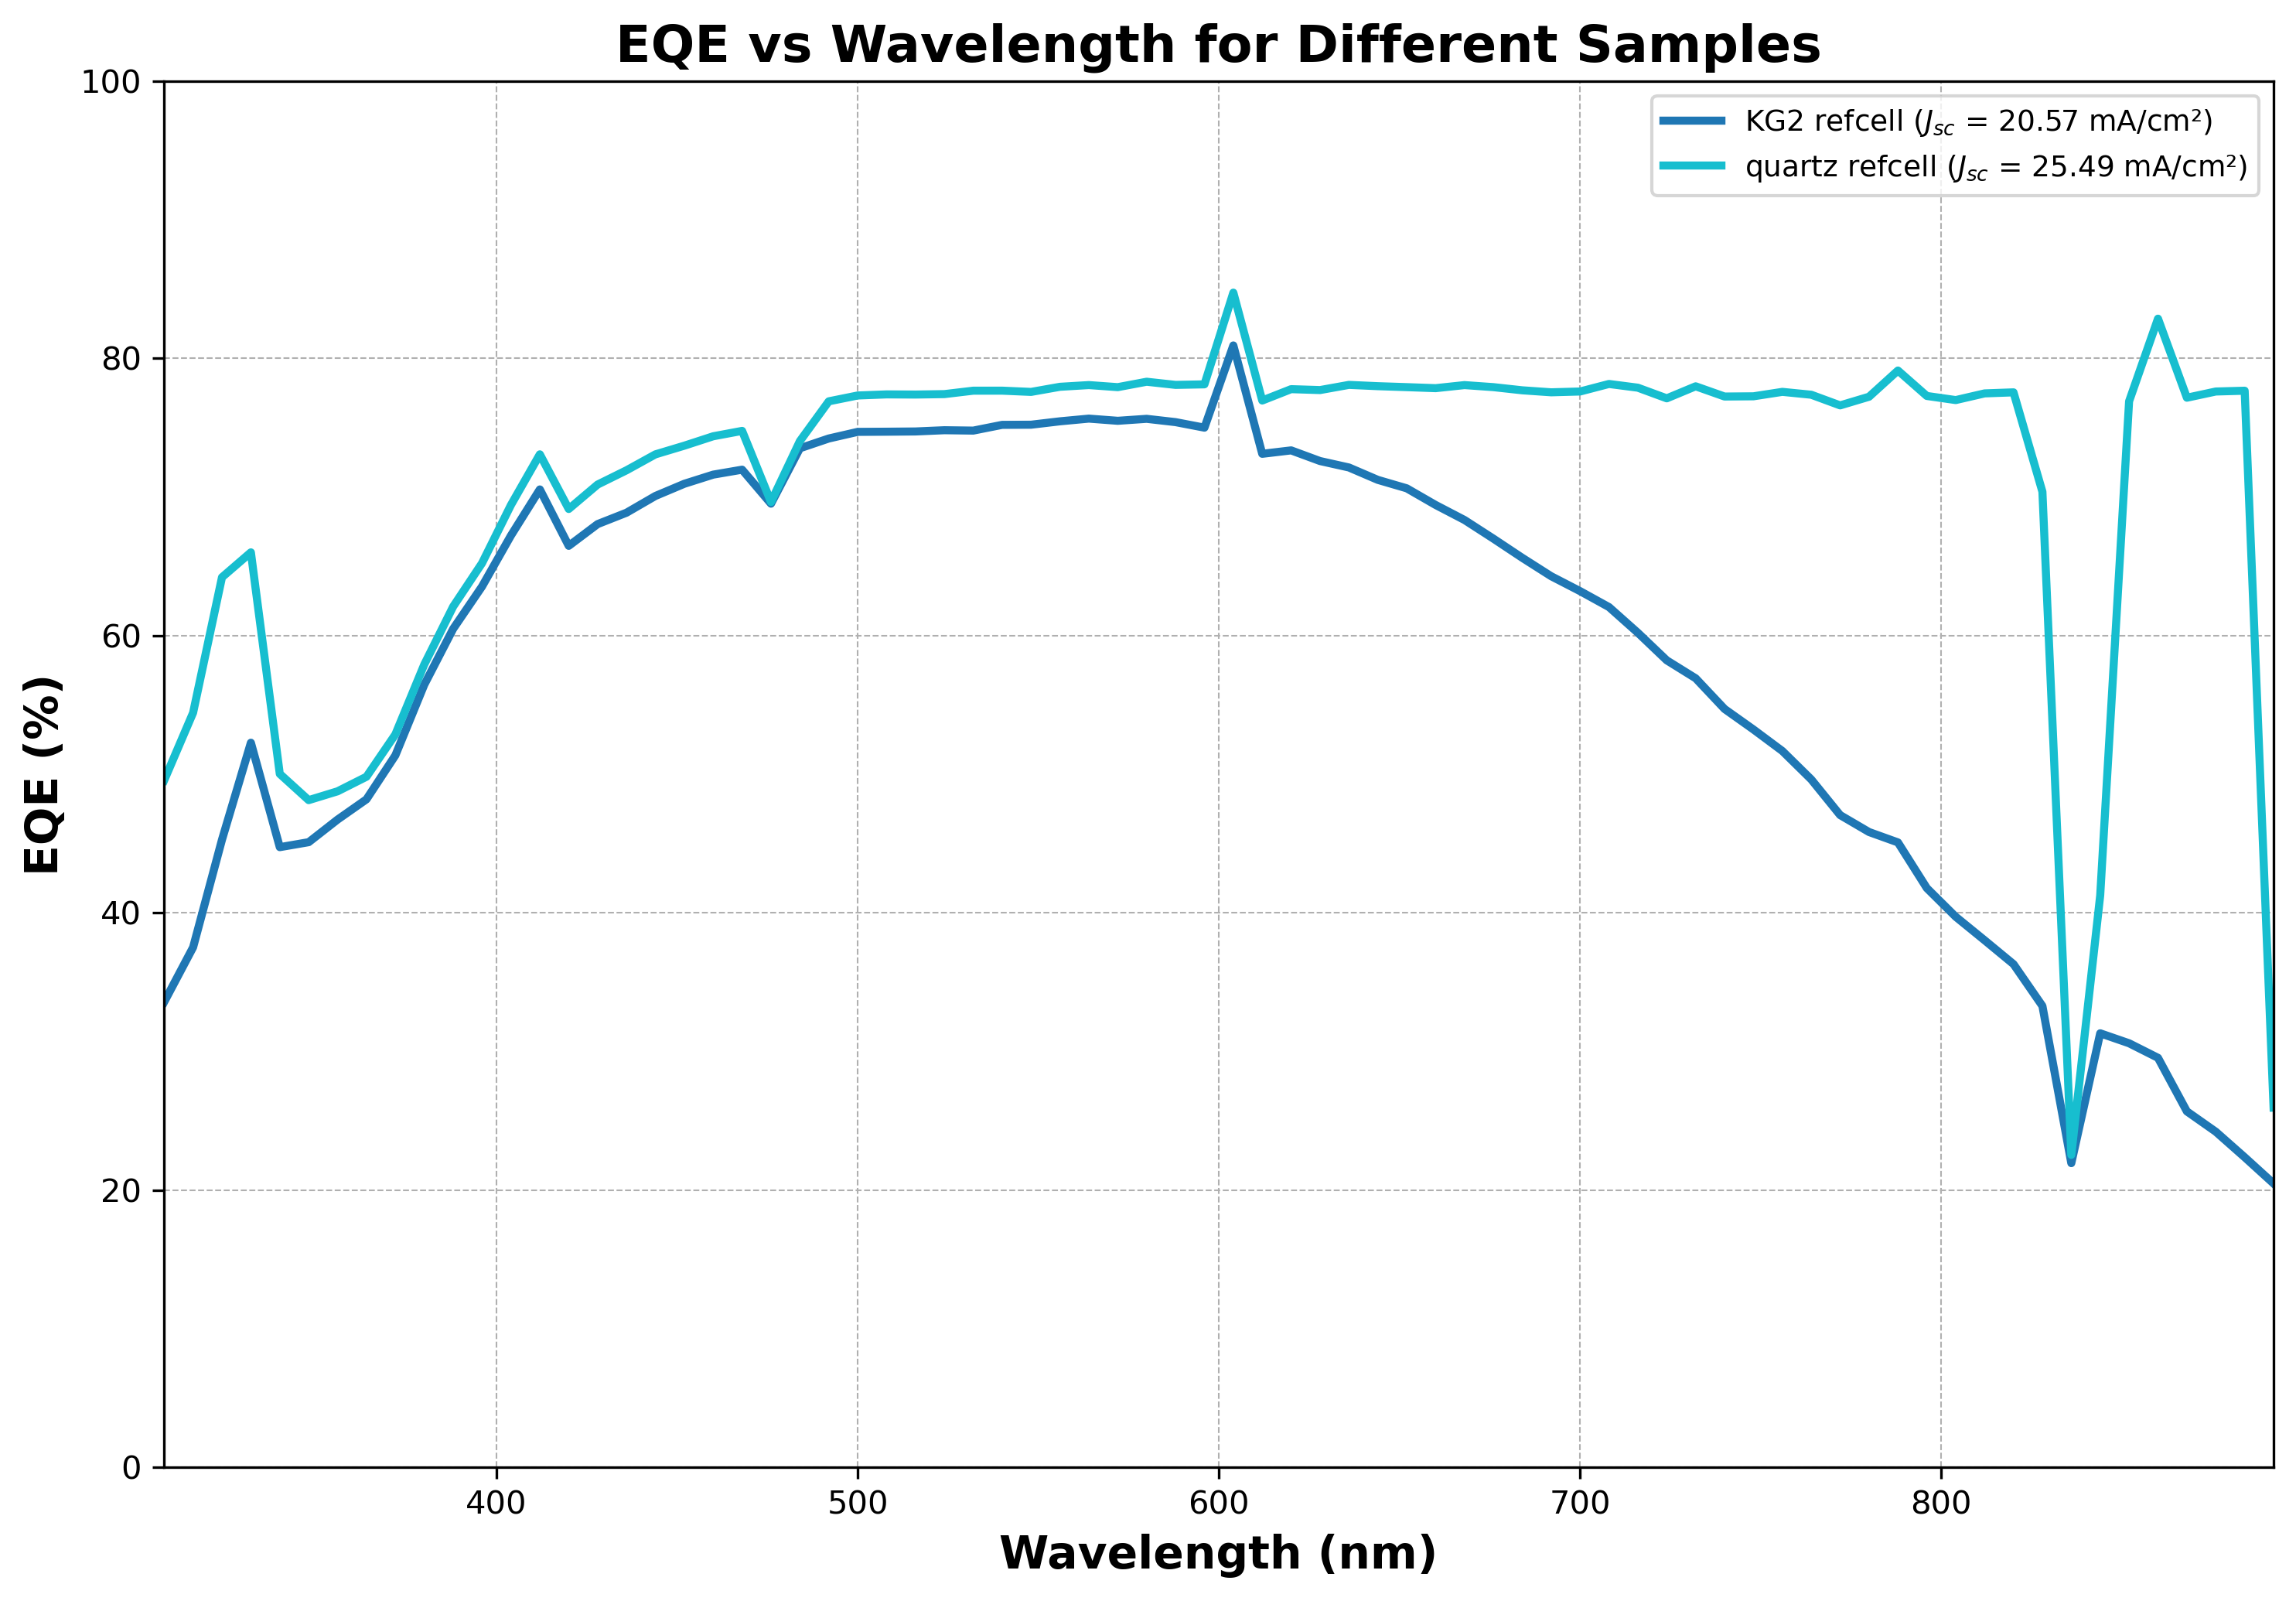

In [14]:
# calc_jsc function
def calc_jsc(eqe_wls, eqe, eqe_error, spectrum_data):
    eqe_wls = np.asarray(eqe_wls)
    AM1p5_wls = spectrum_data['Wvlgth nm']
    AM1p5_irr = spectrum_data['Global tilt  W*m-2*nm-1']
    eqe_interp = interp1d(eqe_wls, eqe, kind='linear')
    max_ind = find_nearest(AM1p5_wls, eqe_wls[-1])
    min_ind = find_nearest(AM1p5_wls, eqe_wls[0])
    wls = AM1p5_wls[min_ind:max_ind]
    irr = AM1p5_irr[min_ind:max_ind]
    irr_photons = (wls * irr * 1e-9) / (1.988e-25)
    irr_photocurrent_density = (irr_photons / 1e4) * 1.602176634e-19 * 1000
    eqe_matched = eqe_interp(wls)
    jsc = sum(eqe_matched * irr_photocurrent_density)
    return jsc

# List all CSV files in the directory
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

# Use the plasma colormap for distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, len(csv_files)))

# Initialize variables to keep track of the overall min and max wavelengths across all datasets
global_min_wavelength = float('inf')
global_max_wavelength = 0

# Loop over each CSV file and plot EQE data
for idx, file in enumerate(csv_files):
    eqe_data = pd.read_csv(file)
    # Check the first 3 EQE values and drop if they are greater than 1
    for wl in eqe_data['wls'].iloc[:3]:
        eqe_data = eqe_data.drop(eqe_data[(eqe_data['wls'] == wl) & (eqe_data['eqe'] > 1)].index)
    wavelengths = eqe_data['wls']
    eqe_values = eqe_data['eqe']
    eqe_errors = eqe_data['eqe_error']

    # Update the global min and max wavelengths
    global_min_wavelength = min(global_min_wavelength, wavelengths.min())
    global_max_wavelength = max(global_max_wavelength, wavelengths.max())

    # Compute Jsc for the sample using calc_jsc
    jsc = calc_jsc(wavelengths, eqe_values, eqe_errors, spectrum_data)

    # Extract sample name from the file name and use it as a label, including the Jsc value with proper subscript notation
    sample_name = f"{file.split('.')[0].replace('_', ' ')} ($J_{{sc}}$ = {jsc:.2f} mA/cm²)"
    
    # Plot the EQE data with increased line width
    ax.plot(wavelengths, eqe_values * 100, label=sample_name, color=colors[idx], linewidth=2.5)

# Configure the plot aesthetics
ax.set_xlabel('Wavelength (nm)', fontsize=14, fontweight='bold')
ax.set_ylabel('EQE (%)', fontsize=14, fontweight='bold')
ax.set_xlim(global_min_wavelength, global_max_wavelength)
ax.set_ylim(0, 100)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('EQE vs Wavelength for Different Samples', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('all_EQE.png', bbox_inches="tight")
plt.show()
